In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')
with open('/srv/scratch/z5297792/Clim_data/Sample_Data/dic_sample_vert_info.pkl', 'rb') as f:
    dic_sample = pickle.load(f)

sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


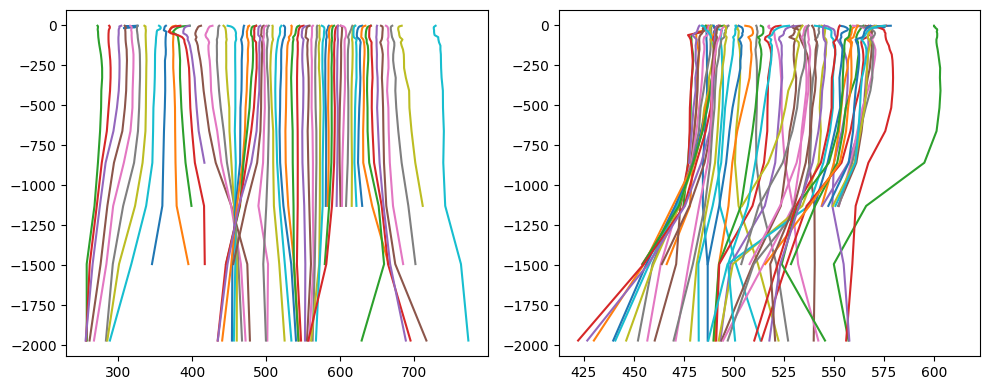

In [3]:
eddy = 382
dic = dic_sample[f'Eddy{eddy}']
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for day in dic.keys():
    df = dic[day].copy()
    df = df[df['Depth'] >= -2000]
    axs[0].plot(df['x'], df['Depth'])
    axs[1].plot(df['y'], df['Depth'])
plt.tight_layout()


### Delta Appraoch to Tilt

In [4]:
sample_eddies

[2749, 8, 2504, 896, 1394, 382, 1967, 926]

In [19]:
eddy   = 896
dic    = dic_sample[f'Eddy{eddy}']
num    = 6
depth_int = 10
max_depth = 1000

ref_day = 7

diffs_x = {}
diffs_y = {}

df_int = pd.DataFrame(columns=['Day', 'Depth', 'x', 'y'])

for d, day in enumerate(dic.keys()):
    if d >= ref_day - num // 2 and d <= ref_day + num // 2:
   
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        depths       = df.index.values
        # interpolate at every 10 m from 0 to max_depth
        target_depths = np.arange(0, max_depth+1, depth_int)
        valid = target_depths[
            (target_depths >= depths.min()) &
            (target_depths <= depths.max())
        ]
        if len(valid) < 2:
            continue
    
        x_i = np.interp(valid, depths, df['x'].values)
        y_i = np.interp(valid, depths, df['y'].values)
    
        dx = np.diff(x_i)
        dy = np.diff(y_i)
    
        delta = np.hypot(dx, dy)
    
        # use the actual depth levels (valid[:-1]) as the Series index
        idx = valid[:-1]
    
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        df = pd.DataFrame({'Day': day[3:], 'Depth': valid, 'x': x_i, 'y': y_i})
    
        if d == ref_day - num // 2:
            df_int = df
        else:
            df_int = pd.concat([df_int, df], ignore_index=True)

# now construct your DataFrames simply by passing the dict-of-series:
df_X = pd.DataFrame(diffs_x)
df_Y = pd.DataFrame(diffs_y)

# each df_X, df_Y will be indexed by the **union** of all depth-levels,
# with NaNs where a particular day didn’t have that depth.
df_X


,$t_{4}$,$t_{5}$,$t_{6}$,$t_{7}$,$t_{8}$,$t_{9}$,$t_{10}$
10,-3.101372,-3.564325,-3.679096,0.729427,-1.501300,-0.015744,-0.937849
20,-1.422354,-2.179912,-0.538198,0.980997,-1.947446,0.033753,0.140197
30,0.293546,0.630666,1.795954,2.024713,-2.659996,0.294417,0.182112
40,2.187647,1.760410,2.609571,3.694896,-0.523161,0.130103,-1.149670
50,-0.280738,-4.306164,-4.266612,-0.658633,0.408661,-1.709535,-3.620395
...,...,...,...,...,...,...,...
800,NaN,1.208682,NaN,NaN,NaN,NaN,NaN
810,NaN,1.208682,NaN,NaN,NaN,NaN,NaN
820,NaN,1.208682,NaN,NaN,NaN,NaN,NaN
830,NaN,1.208682,NaN,NaN,NaN,NaN,NaN


In [20]:
# Calculation of variability at each depth
df_data = pd.DataFrame()
df_data[r'$\Delta x$'] = df_X.mean(axis=1)
df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
df_data[r'$\sigma^2_{\Delta x}$'] = df_X.std(axis=1)
df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.std(axis=1)
df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
df_data['Depth'] = df_data.index 
df_data


,$\Delta x$,$\Delta y$,$\sum{\Delta x}$,$\sum{\Delta y}$,$\sigma^2_{\Delta x}$,$\sigma^2_{\Delta y}$,Total $\sigma^2$,weight,Depth
10,-1.724323,-1.454563,-1.724323,-1.454563,1.765947,1.034292,2.800240,0.357112,10
20,-0.704709,-1.112876,-2.429032,-2.567439,1.180689,0.803897,1.984585,0.503884,20
30,0.365916,-1.277395,-2.063116,-3.844834,1.531175,1.406409,2.937584,0.340416,30
40,1.244256,0.295521,-0.818859,-3.549314,1.785222,1.041216,2.826438,0.353802,40
50,-2.061917,-0.335125,-2.880776,-3.884438,1.987289,1.755972,3.743261,0.267147,50
...,...,...,...,...,...,...,...,...,...
800,1.208682,0.538078,31.358411,8.255420,NaN,NaN,NaN,NaN,800
810,1.208682,0.538078,32.567093,8.793498,NaN,NaN,NaN,NaN,810
820,1.208682,0.538078,33.775776,9.331576,NaN,NaN,NaN,NaN,820
830,1.208682,0.538078,34.984458,9.869655,NaN,NaN,NaN,NaN,830


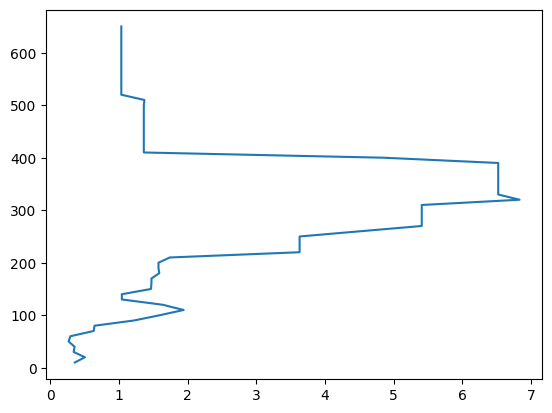

In [24]:
plt.plot(w, z)

In [21]:
# Line of Best Fit

# your data arrays of shape (N,)
x = df_data[r'$\sum{\Delta x}$'].values
y = df_data[r'$\sum{\Delta y}$'].values
z = df_data['Depth'].values
w = df_data['weight'].values

# 1. compute weighted mean
W = np.sum(w)
mean = np.array([np.dot(w, x),
                 np.dot(w, y),
                 np.dot(w, z)]) / W

# 2. center and weight the data
X = np.vstack((x, y, z)).T
Xc = X - mean
Xw = Xc * np.sqrt(w)[:, None]

# 3. SVD on weighted, centered data
_, _, Vt = np.linalg.svd(Xw, full_matrices=False)
direction = Vt[0]   # principal axis

# The best-fit line is:  p(t) = mean + t * direction
t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
p = mean[None, :] + t[:, None] * direction  # shape (100,3)
# or equivalently
p = mean + np.outer(t, direction)          # also (100,3)

# then split back out if you need x,y,z separately:
x_line, y_line, z_line = p.T


LinAlgError: SVD did not converge

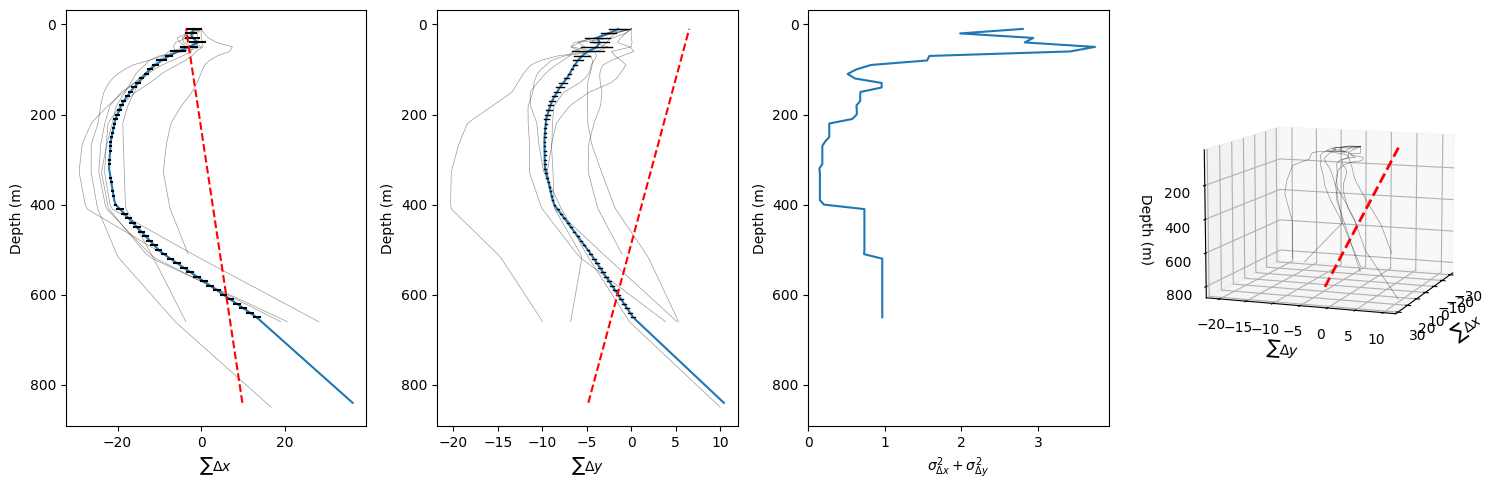

In [18]:
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# set up figure with first two 2D and last one 3D
fig = plt.figure(figsize=(15, 5))

ax0 = fig.add_subplot(1, 4, 1)
ax1 = fig.add_subplot(1, 4, 2, sharey=ax0)
ax3 = fig.add_subplot(1, 4, 3, sharey=ax0)
ax2 = fig.add_subplot(1, 4, 4, projection='3d')

for day in df_int['Day'].unique():
    df = df_int[df_int['Day']==day]
    ax0.plot(df['x']-df.iloc[0]['x'], df['Depth'], alpha=.4, color='k', linewidth=.5)
    ax1.plot(df['y']-df.iloc[0]['y'], df['Depth'], alpha=.4, color='k', linewidth=.5)
    ax2.plot(df['x']-df.iloc[0]['x'], df['y']-df.iloc[0]['y'], df['Depth'],
             alpha=.4, color='k', linewidth=.5)

# — panel 1: sum{x} vs depth with error‐bars and line —
ax0.plot(df_data[r'$\sum{\Delta x}$'], df_data['Depth'], '-')
for k, depth in enumerate(df_data['Depth']):
    x0 = df_data.iloc[k][r'$\sum{\Delta x}$']
    r = df_data.iloc[k][r'$\sigma^2_{\Delta x}$']
    ax0.plot([x0 - r, x0 + r], [depth, depth], 'k-')
ax0.invert_yaxis()
ax0.plot(x_line, z_line, 'r--')
ax0.set_xlabel(r'$\sum\Delta  x$')
ax0.set_ylabel('Depth (m)')

# — panel 2: sum{y} vs depth —
ax1.plot(df_data[r'$\sum{\Delta y}$'], df_data['Depth'], '-')
for k, depth in enumerate(df_data['Depth']):
    y0 = df_data.iloc[k][r'$\sum{\Delta y}$']
    r = df_data.iloc[k][r'$\sigma^2_{\Delta y}$']
    ax1.plot([y0 - r, y0 + r], [depth, depth], 'k-', linewidth=1)
ax1.plot(y_line, z_line, 'r--')
ax1.set_xlabel(r'$\sum\Delta  y$')
ax1.set_ylabel('Depth (m)')

# # — panel 3: 3D circles + best‐fit line —
# theta = np.linspace(0, 2*np.pi, 100)
# for x0, y0, depth, r in zip(
#         df_data[r'$\sum{\Delta x}$'],
#         df_data[r'$\sum{\Delta y}$'],
#         df_data['Depth'],
#         df_data[r'Total $\sigma^2$']
#     ):
#     xs = x0 + r * np.cos(theta)
#     ys = y0 + r * np.sin(theta)
#     zs = np.full_like(theta, depth)
#     ax2.plot(xs, ys, zs, alpha=0.6)

# Plot volitility with depth
ax3.plot(df_data[r'Total $\sigma^2$'], df_data.Depth)
ax3.set_xlim(0, None)
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel(r'$\sigma^2_{\Delta x} + \sigma^2_{\Delta y}$')

# plot best‐fit line in 3D
ax2.plot(x_line, y_line, z_line, 'r--', linewidth=2)

# invert the depth‐axis (z) so that increasing depth goes downwards
ax2.set_zlim(ax2.get_zlim()[::-1])

ax2.view_init(elev=10, azim=20)

ax2.set_xlabel(r'$\sum\Delta  x$')
ax2.set_ylabel(r'$\sum\Delta  y$')
ax2.set_zlabel('Depth (m)')

plt.tight_layout()
plt.show()


In [9]:
def bearing(a, b):
    dx = b[0] - a[0]
    dy = b[1] - a[1]
    angle_rad = np.arctan2(dx, dy)  # note the order: dx, dy
    angle_deg = np.degrees(angle_rad)
    bearing = (angle_deg + 360) % 360
    return bearing

tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
tilt_dist

top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
if top_idx == 1:
    btm_idx = 0
else:
    btm_idx = 1
top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
tilt_direc = ( bearing(btm, top) + 20 ) % 360
print(tilt_dist, tilt_direc)


17.59093317061837 330.17696812884975


### Generalise

In [10]:
sample_eddies

[2749, 8, 2504, 896, 1394, 382, 1967, 926]

In [31]:
def compute_tilt_data(dic, eddy, num=6, depth_int=10, max_depth=1000):
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'Tilt Dis', 'Tilt Dir'])
    
    diffs_x = {}
    diffs_y = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        depths       = df.index.values
        # interpolate at every 10 m from 0 to max_depth
        target_depths = np.arange(0, max_depth+1, depth_int)
        valid = target_depths[
            (target_depths >= depths.min()) &
            (target_depths <= depths.max())
        ]
        if len(valid) < 2:
            continue
    
        x_i = np.interp(valid, depths, df['x'].values)
        y_i = np.interp(valid, depths, df['y'].values)
    
        dx = np.diff(x_i)
        dy = np.diff(y_i)
    
        delta = np.hypot(dx, dy)
    
        # use the actual depth levels (valid[:-1]) as the Series index
        idx = valid[:-1]
    
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    for ref_day in range(num //2, len(dic) - num //2):
    
        df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        
        # Calculation of variability at each depth
        df_data = pd.DataFrame()
        df_data[r'$\Delta x$'] = df_X.mean(axis=1)
        df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
        df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
        df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
        df_data[r'$\sigma^2_{\Delta x}$'] = df_X.std(axis=1)
        df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.std(axis=1)
        df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
        df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
        df_data['Depth'] = df_data.index 
        df_data
        
        # Line of Best Fit
        
        # your data arrays of shape (N,)
        x = df_data[r'$\sum{\Delta x}$'].values
        y = df_data[r'$\sum{\Delta y}$'].values
        z = df_data['Depth'].values
        w = df_data['weight'].values
        
        # 1. compute weighted mean
        W = np.sum(w)
        mean = np.array([np.dot(w, x),
                         np.dot(w, y),
                         np.dot(w, z)]) / W
        
        # 2. center and weight the data
        X = np.vstack((x, y, z)).T
        Xc = X - mean
        Xw = Xc * np.sqrt(w)[:, None]
        
        # 3. SVD on weighted, centered data
        try:
            flag = 0
            _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
        except Exception:
            flag = 1
            print(f"Eddy{eddy} on day {list(dic_sample[f'Eddy{eddy}'].keys())[ref_day][3:]} did not have a measurable profile")
            
        if flag:
            
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic_sample[f'Eddy{eddy}'].keys())[ref_day][3:], 'Tilt Dis': np.nan, 'Tilt Dir': np.nan}
            
        else:
            
            direction = Vt[0]   # principal axis
            
            # The best-fit line is:  p(t) = mean + t * direction
            t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
            p = mean[None, :] + t[:, None] * direction  # shape (100,3)
            # or equivalently
            p = mean + np.outer(t, direction)          # also (100,3)
            
            # then split back out if you need x,y,z separately:
            x_line, y_line, z_line = p.T
            
            tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
            tilt_dist
            
            top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
            if top_idx == 1:
                btm_idx = 0
            else:
                btm_idx = 1
            top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
            btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
            tilt_direc = ( bearing(btm, top) + 20 ) % 360
        
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic_sample[f'Eddy{eddy}'].keys())[ref_day][3:], 'Tilt Dis': tilt_dist, 'Tilt Dir': tilt_direc}
        
    return df_tilt_data


In [26]:
eddy   = 1967
dic    = dic_sample[f'Eddy{eddy}']

df_tilt_data = compute_tilt_data(dic, eddy)
df_tilt_data

,Eddy,Day,Tilt Dis,Tilt Dir
0,1967,7544,14.855789,312.773689
1,1967,7545,10.110887,335.589165
2,1967,7546,6.015905,5.002309
3,1967,7547,3.496057,64.344665
4,1967,7548,5.576354,128.447619
...,...,...,...,...
56,1967,7600,9.214826,144.921737
57,1967,7601,10.222015,162.080212
58,1967,7602,11.432435,173.441832
59,1967,7603,13.901839,169.944635


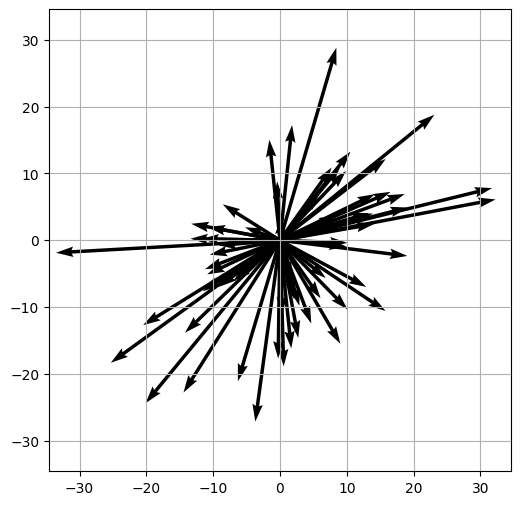

In [27]:
r = df_tilt_data['Tilt Dis'].values
theta = df_tilt_data['Tilt Dir'].values

u = r * np.cos(theta)  # x-component
v = r * np.sin(theta)  # y-component

# Plot quiver from the origin (0, 0)
plt.figure(figsize=(6, 6))
plt.quiver(np.zeros_like(r), np.zeros_like(r), u, v, angles='xy', scale_units='xy', scale=1)
plt.xlim(-max(r)-1, max(r)+1)
plt.ylim(-max(r)-1, max(r)+1)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

In [32]:
df_tilt_data_all = pd.DataFrame()
for eddy in sample_eddies:
    dic = dic_sample[f'Eddy{eddy}']
    df_tilt_data = compute_tilt_data(dic, eddy)
    df_tilt_data_all = pd.concat([df_tilt_data_all, df_tilt_data], ignore_index=True)
    

Eddy896 on day 4385 did not have a measurable profile
Eddy896 on day 4387 did not have a measurable profile
Eddy896 on day 4388 did not have a measurable profile
Eddy896 on day 4403 did not have a measurable profile
Eddy896 on day 4404 did not have a measurable profile
Eddy896 on day 4405 did not have a measurable profile
